## Imports

In [161]:
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
import kaleido
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

## Data Paths

In [162]:
year = 2050

# data dir
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')

# output data
output_data_dir = os.path.join(data_dir, 'output_data')

# input data dir
input_data_dir = os.path.join(data_dir, 'input_data')

# output figure dir
fig_dir = os.path.join(os.path.dirname(os.getcwd()), 'figures', 'suitability_analysis_dotplots')

# path to suitability analysis df
suitability_data_path = os.path.join(output_data_dir, f'capacity_factor_analysis_{year}.csv')

# western interconnection shapefile
wecc_shp_path = os.path.join(input_data_dir, 'wecc_boundary_shp', 'wecc_boundary.shp')

# transmission shapefile
transmission_path = os.path.join(input_data_dir, 'transmission_shp', 'wecc_transmission_250kv.shp')
                                 

## Functions

## Collect Data

In [163]:
state_abbr = {'WA': 'washington',
              'NM':'new_mexico',
              'CA': 'california',
            'OR': 'oregon',
            'ID':'idaho',
              'NV': 'nevada',
              'MT': 'montana',
              'AZ':'arizona',
              'CO': 'colorado',
              'UT':'utah',
              'WY':'wyoming'}

# Define the sorter
sorter = ['baseline', 'dac', 'farmland', 'env_1', 'env_1_1km', 'env_1_5km',
       'env_1_10km', 'env_2', 'env_2_1km', 'env_2_5km', 'env_2_10km',
       'env_3', 'env_3_1km', 'env_3_5km', 'env_3_10km', 'dac_farm_env1',
       'dac_farm_env2', 'dac_farm_env3', 'dac_farm_env1_1km',
       'dac_farm_env2_1km', 'dac_farm_env3_1km', 'dac_farm_env1_5km',
       'dac_farm_env2_5km', 'dac_farm_env3_5km', 'dac_farm_env1_10km',
       'dac_farm_env2_10km', 'dac_farm_env3_10km']

sorter_reduced = ['baseline', 'dac', 'farmland', 'env_1', 'env_1_5km',
       'env_2', 'env_2_5km',
       'env_3',  'env_3_5km', 'dac_farm_env1',
       'dac_farm_env2', 'dac_farm_env3', 
       'dac_farm_env1_5km',
       'dac_farm_env2_5km', 
                  'dac_farm_env3_5km']

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(sorter, range(len(sorter))))
#sorterIndex = dict(zip(sorter_reduced, range(len(sorter_reduced))))

In [164]:
df = pd.read_csv((os.path.join(output_data_dir, 'capacity_factor_analysis_2050.csv')))

# state analysis
wind = df[df.tech_name_simple == 'Wind'].copy()
wind['Rank'] = wind['analysis'].map(sorterIndex)
wind.sort_values(['Rank'], ascending = [False], inplace = True)
wind['clean_grid_mwh'] = wind['clean_grid_mwh'] / 1000000
wind['total_gen'] = wind['total_gen'] / 1000000
wind['diff'] = (wind['total_gen'] - wind['clean_grid_mwh'])/wind['clean_grid_mwh']
region_list = sorted(list(wind.region_name.unique()))
analysis_list = (list(wind.analysis.unique()))

solar = df[df.tech_name_simple == 'Solar PV'].copy()
solar['Rank'] = solar['analysis'].map(sorterIndex)
solar.sort_values(['Rank'], ascending = [False], inplace = True)
solar['clean_grid_mwh'] = solar['clean_grid_mwh'] / 1000000
solar['total_gen'] = solar['total_gen'] / 1000000
solar['diff'] =  (solar['total_gen'] - solar['clean_grid_mwh'])/solar['clean_grid_mwh']
region_list = sorted(list(solar.region_name.unique()))
analysis_list = (list(solar.analysis.unique()))


wind_trading = df[df.tech_name_simple == 'Wind'].copy()
wind_trading = wind_trading.groupby(['gcam_trading_region', 'analysis'], as_index=False).sum()
wind_trading['Rank'] = wind_trading['analysis'].map(sorterIndex)
wind_trading.sort_values(['Rank'], ascending = [False], inplace = True)
wind_trading['clean_grid_mwh'] = wind_trading['clean_grid_mwh'] / 1000000
wind_trading['total_gen'] = wind_trading['total_gen'] / 1000000
wind_trading['diff'] = (wind_trading['total_gen'] - wind_trading['clean_grid_mwh'])/wind_trading['clean_grid_mwh']
trading_region_list = sorted(list(wind_trading.gcam_trading_region.unique()))
wind_trading_analysis_list = (list(wind_trading.analysis.unique()))

solar_trading = df[df.tech_name_simple == 'Solar PV'].copy()
solar_trading = solar_trading.groupby(['gcam_trading_region', 'analysis'], as_index=False).sum()
solar_trading['Rank'] = solar_trading['analysis'].map(sorterIndex)
solar_trading.sort_values(['Rank'], ascending = [False], inplace = True)
solar_trading['clean_grid_mwh'] = solar_trading['clean_grid_mwh'] / 1000000
solar_trading['total_gen'] = solar_trading['total_gen'] / 1000000
solar_trading['diff'] = (solar_trading['total_gen'] - solar_trading['clean_grid_mwh'])/solar_trading['clean_grid_mwh']
trading_region_list = sorted(list(solar_trading.gcam_trading_region.unique()))
solar_trading_analysis_list = (list(solar_trading.analysis.unique()))

wind_trading

,gcam_trading_region,analysis,region_name,tech_name_simple,total_gen,total_km,clean_grid_mwh,Rank,diff
65,SW Grid,dac_farm_env3_10km,arizonacoloradonew_mexicowyoming,WindWindWindWind,0.000000,0,244.499609,26,-1.000000
38,NW Grid,dac_farm_env3_10km,idahomontananevadaoregonutahwashington,WindWindWindWindWindWind,1.555198,39,246.640046,26,-0.993694
11,CA Grid,dac_farm_env3_10km,california,Wind,2.592758,88,154.566960,26,-0.983226
61,SW Grid,dac_farm_env2_10km,arizonacoloradonew_mexicowyoming,WindWindWindWind,1833.183412,43520,244.499609,25,6.497695
7,CA Grid,dac_farm_env2_10km,california,Wind,17.100745,643,154.566960,25,-0.889364
...,...,...,...,...,...,...,...,...,...
1,CA Grid,dac,california,Wind,1052.969129,37512,154.566960,1,5.812382
28,NW Grid,dac,idahomontananevadaoregonutahwashington,WindWindWindWindWindWind,8817.386073,70886,246.640046,1,34.750018
54,SW Grid,baseline,arizonacoloradonew_mexicowyoming,WindWindWindWind,21587.121675,55034,244.499609,0,87.291027
27,NW Grid,baseline,idahomontananevadaoregonutahwashington,WindWindWindWindWindWind,16171.415279,66942,246.640046,0,64.566868


# GCAM-USA Trading Regions

/var/folders/zp/6_04pmq97nq_cq_837pfbx200000gn/T/ipykernel_73680/1202453559.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/zp/6_04pmq97nq_cq_837pfbx200000gn/T/ipykernel_73680/1202453559.py:253: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


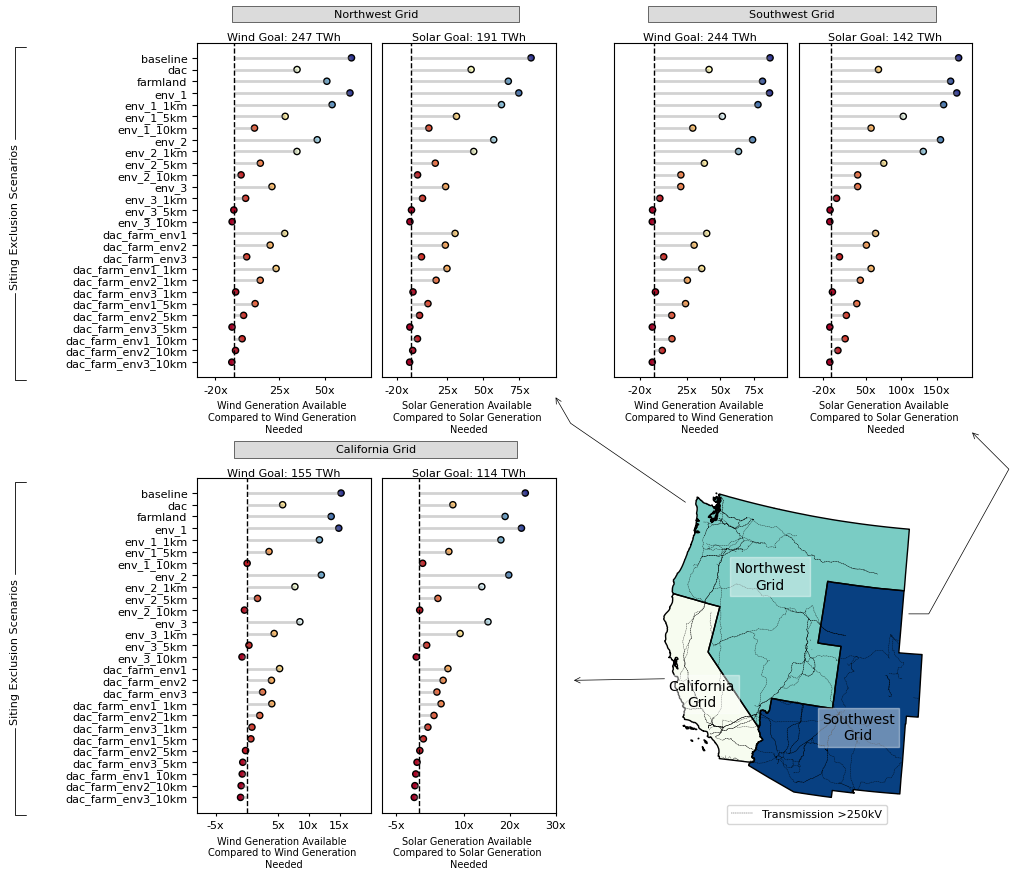

In [165]:
from matplotlib.patches import ConnectionPatch

height = 10
width = 10

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=5, 
                nrows=2,
                width_ratios=[.25, .25, .05, .25,.25], 
                wspace=0.08,
                hspace=0.3,
                height_ratios=[.5, .5])


ax_1a =fig.add_subplot(spec[0,0])
ax_1b =fig.add_subplot(spec[0,1])

ax_1c =fig.add_subplot(spec[0,3])
ax_1d =fig.add_subplot(spec[0,4])

ax_2a =fig.add_subplot(spec[1,0])
ax_2b =fig.add_subplot(spec[1,1])

ax_2c =fig.add_subplot(spec[1,3:])


wecc_shp.plot(ax=ax_2c,  column='trading_region', cmap='GnBu')
wecc_shp.boundary.plot(ax=ax_2c, lw=1, color='black')
transmission.plot(ax=ax_2c, color='black',linestyle='dashed', lw=.25)



# region labels
ax_2c.set_axis_off()
x=.42
y=.75
ax_2c.annotate(f"Northwest\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.73
y=.3
ax_2c.annotate(f"Southwest\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.18
y=.4 
ax_2c.annotate(f"California\nGrid", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))


# Northwest Grid
region = 'NW Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]

x_val_max = plot_df['diff'].max() + 10
x_val_min = plot_df['diff'].min() - 10

my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_1a
ax.hlines(y=my_range, xmin=0, xmax=plot_df['diff'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['diff'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.annotate(f"Wind Goal: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.03), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')#, bbox=dict(boxstyle='square', fc='white', color='white', lw=.5))
ax.set_xlim(left=-20, right=75)
ax.set_xticks(ticks=[-10,25,50], labels=['-20x','25x','50x'])

df = solar_trading
plot_df = df[df.gcam_trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_1b
ax.hlines(y=my_range, xmin=0, xmax=plot_df['diff'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['diff'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x =  0, linestyle='dashed', color = 'black', lw=1)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=True, top=False, left=False, labelbottom=True, size=2, labelsize=8)
ax.annotate(f"Solar Goal: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.03), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')#, bbox=dict(boxstyle='square', fc='white', color='white', lw=.5))
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-20, right=100)
ax.set_xticks(ticks=[-10,25,50, 75], labels=['-20x','25x','50x', '75x'])

# Southwest Grid
region = 'SW Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_1c
ax.hlines(y=my_range, xmin=0, xmax=plot_df['diff'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['diff'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.annotate(f"Wind Goal: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.03), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')#, bbox=dict(boxstyle='square', fc='white', color='white', lw=.5))
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-30, right=100)
ax.set_xticks(ticks=[-10,25,50, 75], labels=['-20x','25x','50x', '75x'])

df = solar_trading
plot_df = df[df.gcam_trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_1d
ax.hlines(y=my_range, xmin=0, xmax=plot_df['diff'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['diff'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=True, top=False, left=False, labelbottom=True, size=2, labelsize=8)
ax.annotate(f"Solar Goal: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.03), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')#, bbox=dict(boxstyle='square', fc='white', color='white', lw=.5))
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-45, right=200)
ax.set_xticks(ticks=[-10,50,100, 150], labels=['-20x','50x', '100x', '150x'])

# CA Grid
region = 'CA Grid'
df = wind_trading
plot_df = df[df.gcam_trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_2a
ax.hlines(y=my_range, xmin=0, xmax=plot_df['diff'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['diff'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.annotate(f"Wind Goal: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.03), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')#, bbox=dict(boxstyle='square', fc='white', color='white', lw=.5))
ax.set_xlim(left=-8, right=20)
ax.set_xticks(ticks=[-5, 5, 10,15], labels=['-5x', '5x', '10x','15x'])

df = solar_trading
plot_df = df[df.gcam_trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_2b
ax.hlines(y=my_range, xmin=0, xmax=plot_df['diff'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['diff'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = 0, linestyle='dashed', color = 'black', lw=1)


ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=True, top=False, left=False, labelbottom=True, size=2, labelsize=8)
ax.annotate(f"Solar Goal: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.03), xytext=(.5, 1.03), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top')#, bbox=dict(boxstyle='square', fc='white', color='white', lw=.5))
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.set_xlim(left=-8, right=30)
ax.set_xticks(ticks=[-5,10,20,30], labels=['-5x','10x','20x','30x'])


# TWh label
for ax in [ax_1a,  ax_1c, ax_2a, ]:
    ax.set_xlabel('Wind Generation Available \nCompared to Wind Generation \nNeeded', size=7)
for ax in [ax_1b,  ax_1d, ax_2b]:
    ax.set_xlabel('Solar Generation Available \nCompared to Solar Generation \nNeeded', size=7)

#NW arrow
arrow = ConnectionPatch(
    [-2200000,1500000],
    [100,-2],
    coordsA=ax_2c.transData,
    coordsB=ax_1b.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
arrow.set_connectionstyle("arc", angleA=-75, angleB=-60, armA=0, armB=30, rad=0)
fig.patches.append(arrow)

# CA arrow
arrow = ConnectionPatch(
    [-2350000,235000],
    [34,11],
    coordsA=ax_2c.transData,
    coordsB=ax_2b.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
fig.patches.append(arrow)

# SW arrow
arrow = ConnectionPatch(
    [-600000,700000],
    [200,-5],
    coordsA=ax_2c.transData,
    coordsB=ax_1d.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
arrow.set_connectionstyle("arc", angleA=0, angleB=-45, armA=20, armB=52, rad=0)
fig.patches.append(arrow)


# region labels
x=1.03
y=1.1
ax_1a.annotate(f"                            Northwest Grid                            ", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', lw=.5, alpha=.8, color='black'))
ax_1c.annotate(f"                            Southwest Grid                            ", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', lw=.5, alpha=.8, color='black'))
ax_2a.annotate(f"                            California Grid                            ", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='lightgray', lw=.5, alpha=.8, color='black'))

ax_1a.annotate('Siting Exclusion Scenarios', xy=(-1.05, .7), xytext=(-1.05, .7), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))

ax_2a.annotate('Siting Exclusion Scenarios', xy=(-1.05, .7), xytext=(-1.05, .7), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))


# ax_1a.annotate(
#     'Net Zero Goal',
#     xy=(30, .4), xycoords='data',
#     xytext=(30, 8.5), textcoords='offset points',fontsize=7,
#     arrowprops=dict(arrowstyle="->",  lw=.4,
#                     connectionstyle="angle,angleA=90,angleB=0,rad=0"))

# ax_1a.annotate(
#     'Generation\n Potential',
#     xy=(2000, 3), xycoords='data',
#     xytext=(28, 13), textcoords='offset points',fontsize=7,
#     arrowprops=dict(arrowstyle="->",  lw=.4,
#                     connectionstyle="angle,angleA=90,angleB=0,rad=0"))

volt = Line2D([0], [0], color='black',linestyle='dashed', lw=.25, label='Transmission >250kV')
ax_2c.legend(handles=[volt], fontsize=8, title_fontsize = 8, loc='lower right', ncol=1, facecolor='white', bbox_to_anchor=(.85, -.05))
plt.tight_layout()
#plt.savefig(os.path.join(fig_dir, 'gcam_grid_analysis.png'), dpi=300)

fig.show()

# State-level Available Generation

### Wind

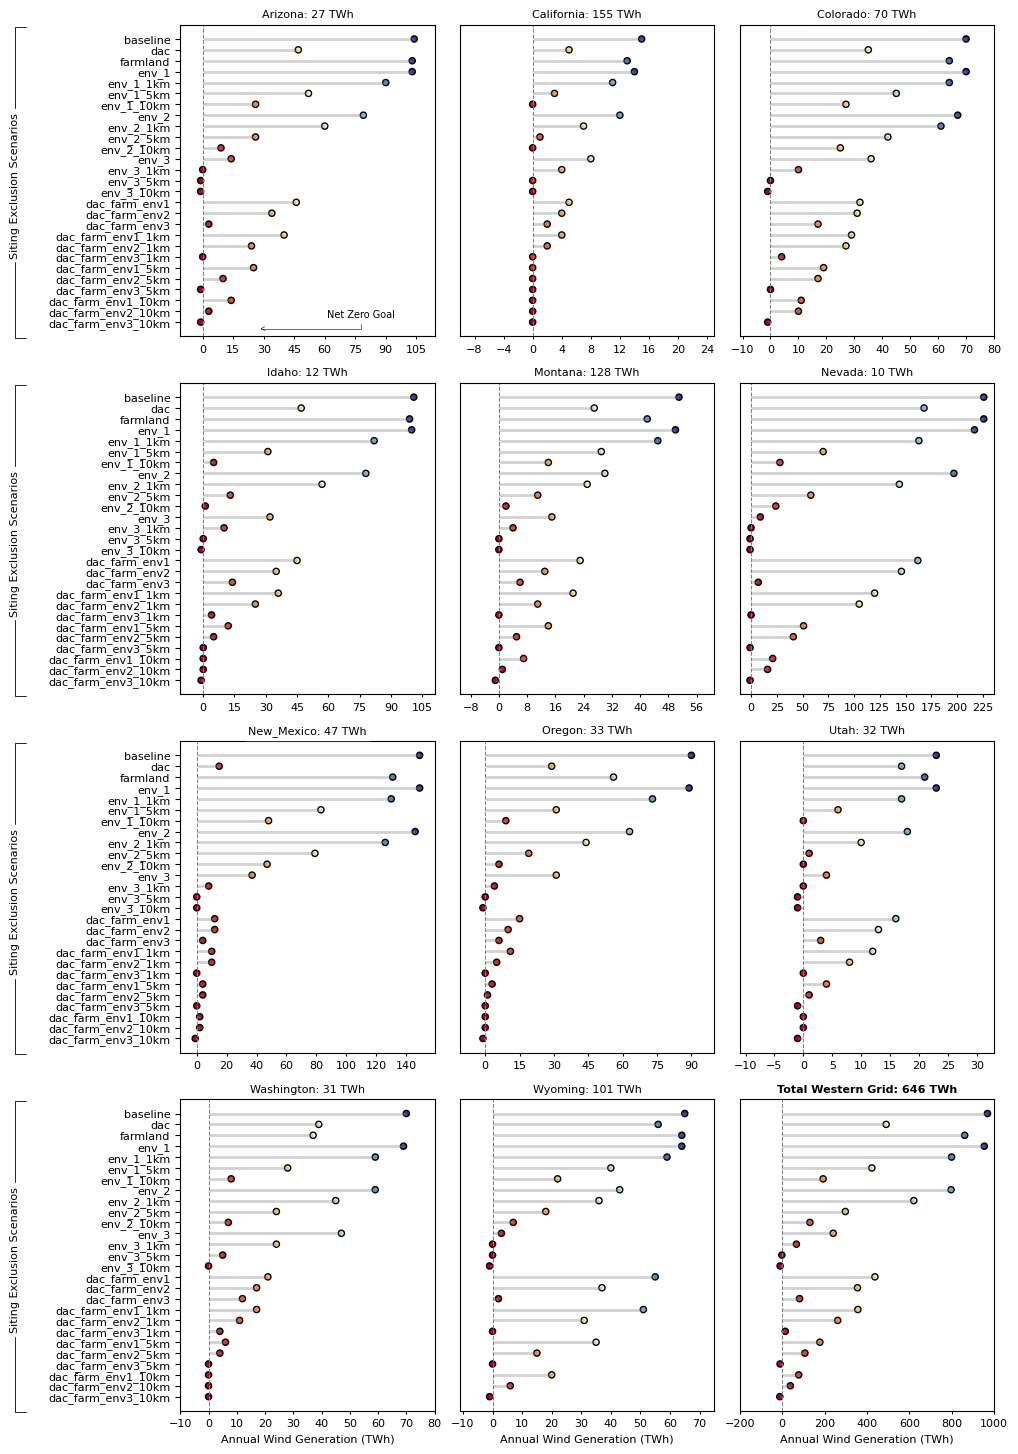

In [95]:
### height = 18
width = 10.5

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=3, 
                nrows=4,
                width_ratios=[.33, .33, .33], 
                wspace=0.1,
                hspace=0.15,
                height_ratios=[.25, .25, .25, .25])


ax_1a =fig.add_subplot(spec[0,0])
ax_1b =fig.add_subplot(spec[0,1])
ax_1c =fig.add_subplot(spec[0,2])

ax_2a =fig.add_subplot(spec[1,0])
ax_2b =fig.add_subplot(spec[1,1])
ax_2c =fig.add_subplot(spec[1,2])

ax_3a =fig.add_subplot(spec[2,0])
ax_3b =fig.add_subplot(spec[2,1])
ax_3c =fig.add_subplot(spec[2,2])

ax_4a =fig.add_subplot(spec[3,0])
ax_4b =fig.add_subplot(spec[3,1])
ax_4c =fig.add_subplot(spec[3,2])

#ax_4c.set_axis_off()
ax_list = [ax_1a, ax_1b, ax_1c, ax_2a, ax_2b, ax_2c, ax_3a, ax_3b, ax_3c, ax_4a, ax_4b]

import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
for i in range(len(region_list)):

    region = region_list[i]
    plot_df = wind[wind.region_name == region].copy()
    plot_df['diff'] = plot_df['diff'].astype(int)
    my_range=range(1,len(plot_df.index)+1)
    
    vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())

    x_val_max = plot_df['diff'].max() + 10
    x_val_min = plot_df['diff'].min() - 10

    ax_list[i].hlines(y=my_range, xmin=0, xmax=plot_df['diff'], color='grey', alpha=.35, lw=2)
    ax_list[i].scatter(plot_df['diff'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , 
                cmap='RdYlBu', vmin=0, vmax=vmax)

    # # Add title and axis names
    ax_list[i].set_xlim(right=x_val_max, left=x_val_min)
    ax_list[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax_list[i].xaxis.set_major_formatter('{x}x')
    
    ax_list[i].axvline(x =0, linestyle='dashed', color = 'gray', lw=.75)
    ax_list[i].set_yticks(my_range)
    ax_list[i].set_yticklabels(analysis_list)
    plt.setp(ax_list[i].get_yticklabels(), size=8)
    ax_list[i].tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
    
    if i in [1, 2, 4, 5, 7, 8, 10]:
        ax_list[i].tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
    ax_list[i].annotate(f"{region.title()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                        fontsize=8, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'))
            #arrowprops=dict(arrowstyle='-[, widthB=11.2, lengthB=2', lw=.75, color='k'))


west_df = wind.copy()
west_df = west_df[['analysis', 'Rank','diff', 'total_gen', 'clean_grid_mwh']].groupby(['analysis', 'Rank'], as_index=False).sum()
west_df.sort_values(['Rank'], ascending = [False], inplace = True)
my_range=range(1,len(west_df.index)+1)
    
vmax =max(west_df.total_gen.max(), west_df.clean_grid_mwh.max())

ax_4c.hlines(y=my_range, xmin=0, xmax=west_df['diff'], color='grey', alpha=.35, lw=2)
ax_4c.scatter(west_df['diff'], my_range, c=west_df['total_gen'], s = 20, edgecolor='black', alpha=1 , 
                cmap='RdYlBu', vmin=-100, vmax=vmax)
ax_4c.axvline(x = 0, linestyle='dashed', color = 'gray', lw=.75)
ax_4c.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax_4c.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax_4c.annotate(f"Total Western Grid: {int(round(west_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                        fontsize=8, ha='center', va='top', weight='bold',
                        bbox=dict(boxstyle='square', fc='white', color='white'))

ax_4a.set_xlabel('Annual Wind Generation (TWh)', size=8)
ax_4b.set_xlabel('Annual Wind Generation (TWh)', size=8)
ax_4c.set_xlabel('Annual Wind Generation (TWh)', size=8)

ax_4c.set_xlim(right=1000, left=-200)
ax_1a.annotate(
    'Net Zero Goal',
    xy=(27, .4), xycoords='data',
    xytext=(50, 8.5), textcoords='offset points',fontsize=7,
    arrowprops=dict(arrowstyle="->",  lw=.4,
                    connectionstyle="angle,angleA=90,angleB=0,rad=0"))

ax_1a.annotate(
    'Generation Potential',
    xy=(870, 3), xycoords='data',
    xytext=(30, 13), textcoords='offset points',fontsize=7,
    arrowprops=dict(arrowstyle="->",  lw=.4,
                    connectionstyle="angle,angleA=90,angleB=0,rad=3"))

ax_1a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))

ax_2a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))
ax_3a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))

ax_4a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))

plt.show()

#### Solar PV

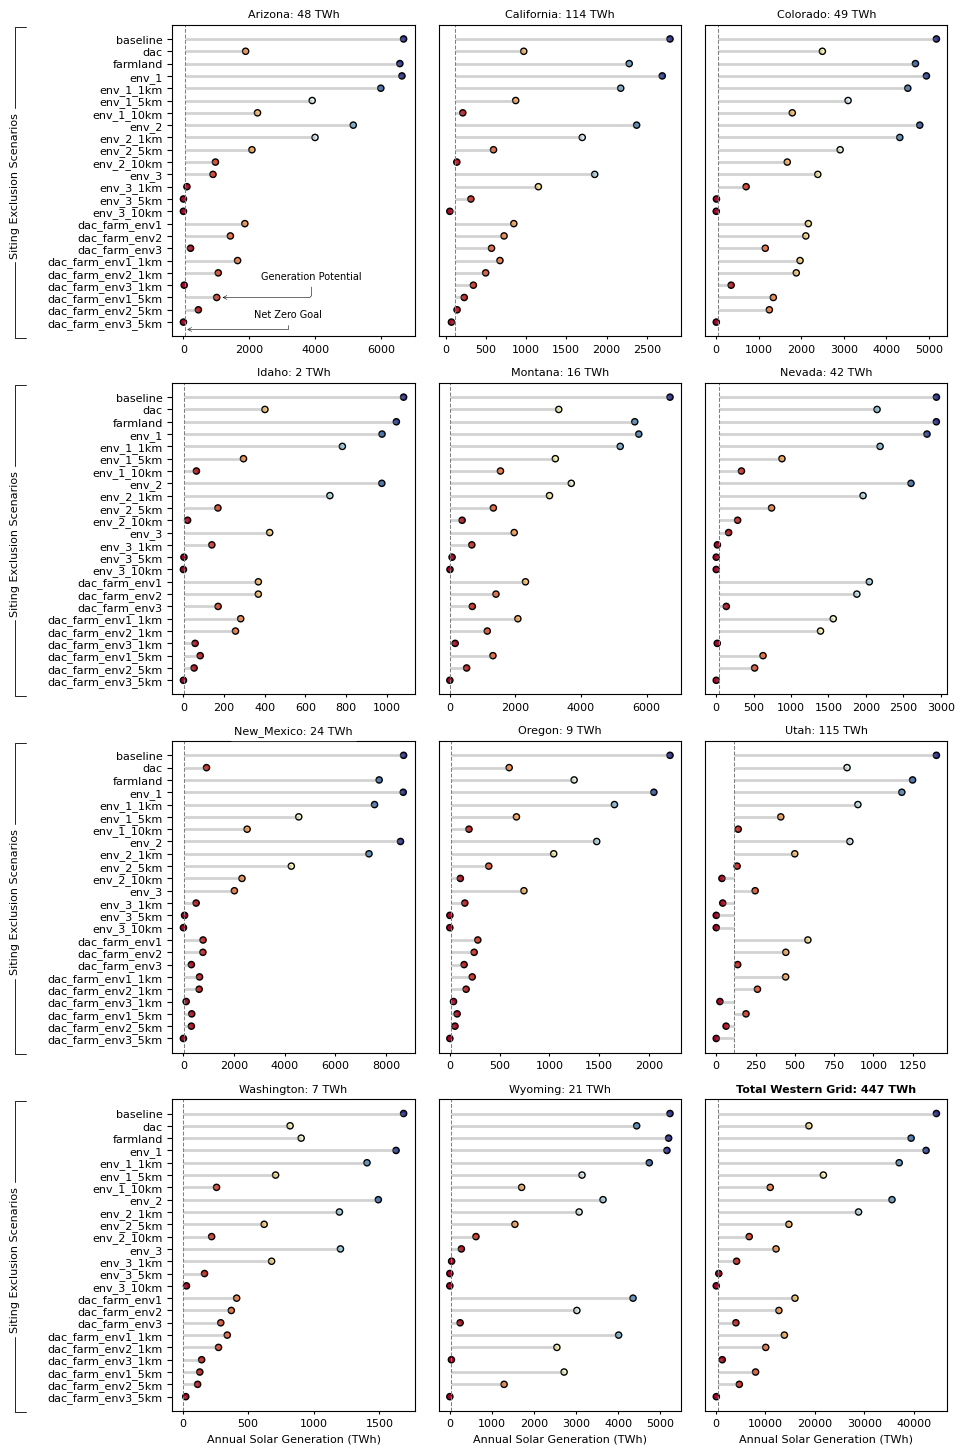

In [10]:
height = 18
width = 10

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=3, 
                nrows=4,
                width_ratios=[.33, .33, .33], 
                wspace=0.1,
                hspace=0.15,
                height_ratios=[.25, .25, .25, .25])


ax_1a =fig.add_subplot(spec[0,0])
ax_1b =fig.add_subplot(spec[0,1])
ax_1c =fig.add_subplot(spec[0,2])

ax_2a =fig.add_subplot(spec[1,0])
ax_2b =fig.add_subplot(spec[1,1])
ax_2c =fig.add_subplot(spec[1,2])

ax_3a =fig.add_subplot(spec[2,0])
ax_3b =fig.add_subplot(spec[2,1])
ax_3c =fig.add_subplot(spec[2,2])

ax_4a =fig.add_subplot(spec[3,0])
ax_4b =fig.add_subplot(spec[3,1])
ax_4c =fig.add_subplot(spec[3,2])

#ax_4c.set_axis_off()
ax_list = [ax_1a, ax_1b, ax_1c, ax_2a, ax_2b, ax_2c, ax_3a, ax_3b, ax_3c, ax_4a, ax_4b]

for i in range(len(region_list)):

    region = region_list[i]
    plot_df = solar[solar.region_name == region]
    my_range=range(1,len(plot_df.index)+1)
    
    vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())

    ax_list[i].hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
    ax_list[i].scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , 
                cmap='RdYlBu', vmin=0, vmax=vmax)

    # # Add title and axis names
    ax_list[i].axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
    ax_list[i].set_yticks(my_range)
    ax_list[i].set_yticklabels(analysis_list)
    plt.setp(ax_list[i].get_yticklabels(), size=8)
    ax_list[i].tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
    
    if i in [1, 2, 4, 5, 7, 8, 10]:
        ax_list[i].tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
    ax_list[i].annotate(f"{region.title()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                        fontsize=8, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white', color='white'))
            #arrowprops=dict(arrowstyle='-[, widthB=11.2, lengthB=2', lw=.75, color='k'))

west_df = solar.copy()
west_df = west_df[['analysis', 'Rank', 'total_gen', 'clean_grid_mwh']].groupby(['analysis', 'Rank'], as_index=False).sum()
west_df.sort_values(['Rank'], ascending = [False], inplace = True)

my_range=range(1,len(west_df.index)+1)
    
vmax =max(west_df.total_gen.max(), west_df.clean_grid_mwh.max())

ax_4c.hlines(y=my_range, xmin=west_df['clean_grid_mwh'], xmax=west_df['total_gen'], color='grey', alpha=.35, lw=2)
ax_4c.scatter(west_df['total_gen'], my_range, c=west_df['total_gen'], s = 20, edgecolor='black', alpha=1 , 
                cmap='RdYlBu', vmin=0, vmax=vmax)
ax_4c.axvline(x = west_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax_4c.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax_4c.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax_4c.annotate(f"Total Western Grid: {int(round(west_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                        fontsize=8, ha='center', va='top', weight='bold',
                        bbox=dict(boxstyle='square', fc='white', color='white'))

ax_4a.set_xlabel('Annual Solar Generation (TWh)', size=8)
ax_4b.set_xlabel('Annual Solar Generation (TWh)', size=8)
ax_4c.set_xlabel('Annual Solar Generation (TWh)', size=8)


ax_1a.annotate(
    'Net Zero Goal',
    xy=(27, .4), xycoords='data',
    xytext=(50, 8.5), textcoords='offset points',fontsize=7,
    arrowprops=dict(arrowstyle="->",  lw=.4,
                    connectionstyle="angle,angleA=90,angleB=0,rad=0"))

ax_1a.annotate(
    'Generation Potential',
    xy=(1100, 3), xycoords='data',
    xytext=(30, 13), textcoords='offset points',fontsize=7,
    arrowprops=dict(arrowstyle="->",  lw=.4,
                    connectionstyle="angle,angleA=90,angleB=0,rad=3"))

ax_1a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))

ax_2a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))
ax_3a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))

ax_4a.annotate('Siting Exclusion Scenarios', xy=(-.65, .72), xytext=(-.65, .72), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=14, lengthA=1, angleA=90',lw=.6, color='k'))

plt.show()

# NERC Trading Regions

In [11]:
wecc_shp = gpd.read_file(wecc_shp_path)
wecc_shp['trading_region'] = wecc_shp['STATE_ABBR'].map(state_abbr).map(gcam_trading_regions)
state_shp = wecc_shp.copy()
wecc_shp = wecc_shp.dissolve(by='trading_region', as_index=False)

transmission = gpd.read_file(transmission_path)

trading_list = []
for v in trading_regions.values():
    if v in trading_list:
        pass
    else:
        trading_list.append(v)

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of labels (24).

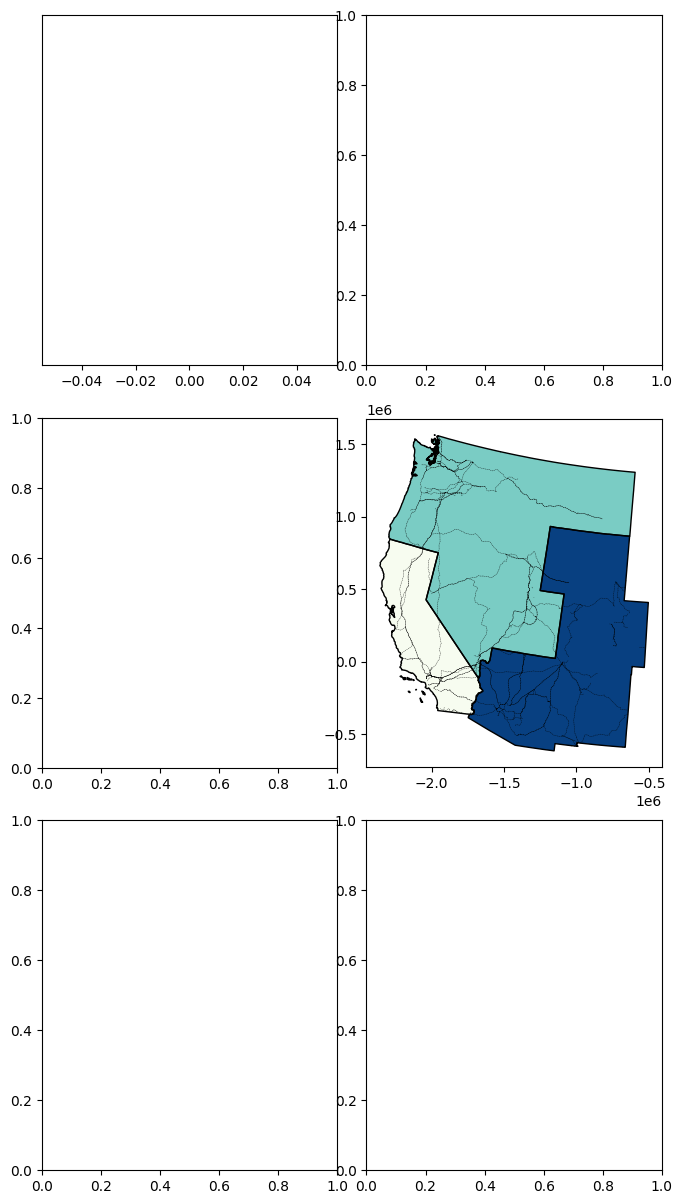

In [12]:
from matplotlib.patches import ConnectionPatch

height = 15
width = 8

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=2, 
                nrows=3,
                width_ratios=[.5, .5], 
                wspace=0.1,
                hspace=0.15,
                height_ratios=[.33, .33, .33])


ax_1a =fig.add_subplot(spec[0,0])
ax_1b =fig.add_subplot(spec[0,1])

ax_2a =fig.add_subplot(spec[1,0])
ax_2b =fig.add_subplot(spec[1,1])

ax_3a =fig.add_subplot(spec[2,0])
ax_3b =fig.add_subplot(spec[2,1])



wecc_shp.plot(ax=ax_2b,  column='trading_region', cmap='GnBu')
wecc_shp.boundary.plot(ax=ax_2b, lw=1, color='black')

transmission.plot(ax=ax_2b, color='black',linestyle='dashed', lw=.25)

ax_list = [ax_1a, ax_1b, ax_2a, ax_3a, ax_3b]

df = wind_trading

# PNW (NWPP)
region = 'NWPP'
plot_df = df[df.trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_1a
ax.hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
#ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.annotate(f"{region.upper()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', color='white'))

# Center (BASN)
region = 'BASN'
plot_df = df[df.trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_1b
ax.hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.annotate(f"{region.upper()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', color='white'))


# California (CASO)
region = 'CASO'
plot_df = df[df.trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_2a
ax.hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
#ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.annotate(f"{region.upper()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', color='white'))

# Southwest (SRSG)
region = 'SRSG'
plot_df = df[df.trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_3a
ax.hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
#ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.annotate(f"{region.upper()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', color='white'))


# Colorado (RMRG)
region = 'RMRG'
plot_df = df[df.trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_3b
ax.hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.annotate(f"{region.upper()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', color='white'))


ax_2b.set_axis_off()
x=.3
y=.85
ax_2b.annotate(f"NWPP", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.5
y=.57
ax_2b.annotate(f"BASN", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.18
y=.4 
ax_2b.annotate(f"CASO", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))

x=.63
y=.22
ax_2b.annotate(f"SRSG", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))

x=.8
y=.41
ax_2b.annotate(f"RMRG", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))

ax_2a.annotate("dd", xy=(2500, 25.5), xytext=(2500, 25.5), color='red', 
            arrowprops=dict(arrowstyle="->"))





arrow = ConnectionPatch(
    [-2200000,1500000],
    [14500,-2],
    coordsA=ax_2b.transData,
    coordsB=ax_1a.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
    #connectionstyle="arc"#dict(arrowstyle="arc", angleA=-90, angleB=0, armA=30, armB=30, rad=0)
)
arrow.set_connectionstyle("arc", angleA=-75, angleB=-60, armA=0, armB=30, rad=0)
fig.patches.append(arrow)

arrow = ConnectionPatch(
    [-2350000,240000],
    [2800,10],
    coordsA=ax_2b.transData,
    coordsB=ax_2a.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
fig.patches.append(arrow)


arrow = ConnectionPatch(
    [-1650000,-500000],
    [14000,26],
    coordsA=ax_2b.transData,
    coordsB=ax_3a.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
arrow.set_connectionstyle("arc", angleA=0, angleB=45, armA=0, armB=50, rad=0)
fig.patches.append(arrow)

arrow = ConnectionPatch(
    [-600000,700000],
    [11000,-2],
    coordsA=ax_2b.transData,
    coordsB=ax_1b.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
arrow.set_connectionstyle("arc", angleA=0, angleB=-45, armA=20, armB=30, rad=0)
fig.patches.append(arrow)


arrow = ConnectionPatch(
    [-450000,200000],
    [5000,26],
    coordsA=ax_2b.transData,
    coordsB=ax_3b.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
arrow.set_connectionstyle("arc", angleA=0, angleB=45, armA=20, armB=45, rad=0)
fig.patches.append(arrow)


ax_3a.set_xlabel('Annual Wind Generation (TWh)', size=8)
ax_3b.set_xlabel('Annual Wind Generation (TWh)', size=8)


ax_1a.annotate(
    'Net Zero Goal',
    xy=(30, .4), xycoords='data',
    xytext=(50, 8.5), textcoords='offset points',fontsize=7,
    arrowprops=dict(arrowstyle="->",  lw=.4,
                    connectionstyle="angle,angleA=90,angleB=0,rad=0"))

ax_1a.annotate(
    'Generation Potential',
    xy=(2500, 3), xycoords='data',
    xytext=(30, 13), textcoords='offset points',fontsize=7,
    arrowprops=dict(arrowstyle="->",  lw=.4,
                    connectionstyle="angle,angleA=90,angleB=0,rad=0"))

ax_1a.annotate('Siting Exclusion Scenarios', xy=(-.55, .7), xytext=(-.55, .7), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))

ax_2a.annotate('Siting Exclusion Scenarios', xy=(-.55, .7), xytext=(-.55, .7), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))
ax_3a.annotate('Siting Exclusion Scenarios', xy=(-.55, .7), xytext=(-.55, .7), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))



plt.show()

/var/folders/zp/6_04pmq97nq_cq_837pfbx200000gn/T/ipykernel_37622/2404939564.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(analysis_list)
/var/folders/zp/6_04pmq97nq_cq_837pfbx200000gn/T/ipykernel_37622/2404939564.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(analysis_list)


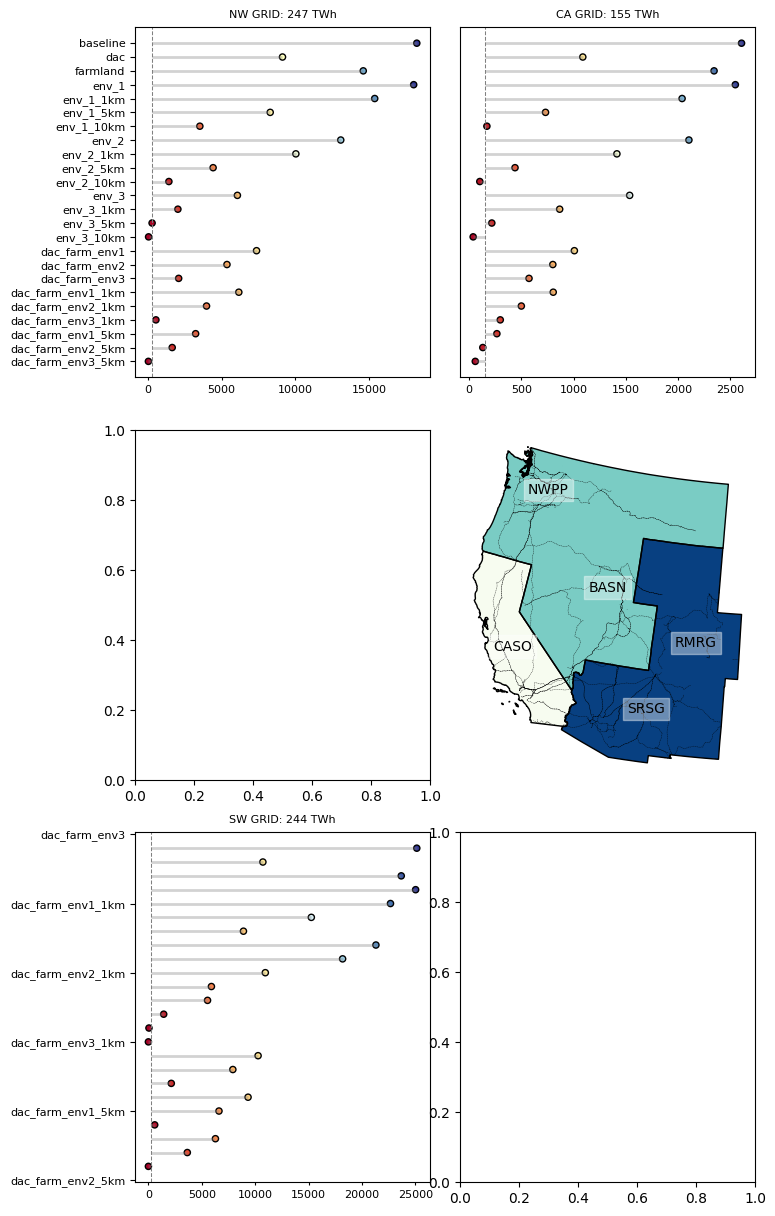

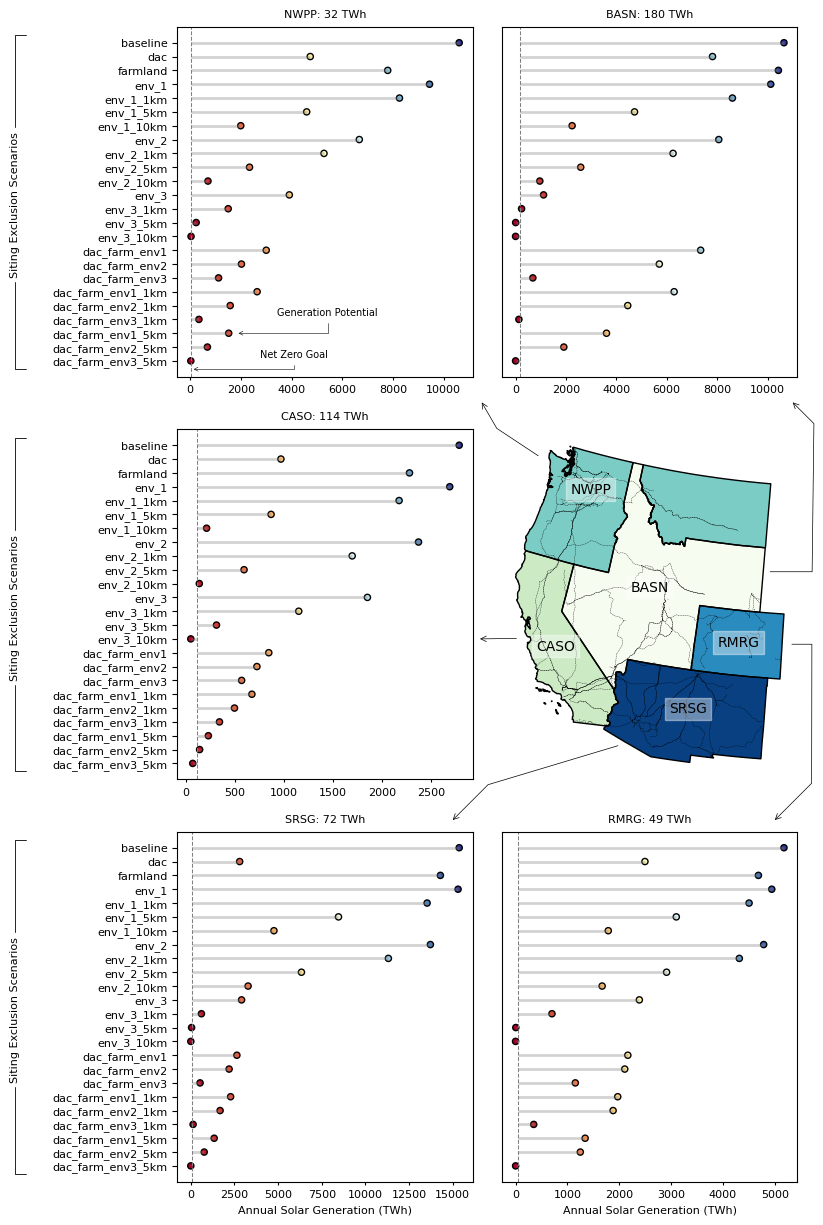

In [239]:
from matplotlib.patches import ConnectionPatch

height = 15
width = 8

fig = plt.figure()
fig.set_figheight(height)
fig.set_figwidth(width)

spec = GridSpec(ncols=2, 
                nrows=3,
                width_ratios=[.5, .5], 
                wspace=0.1,
                hspace=0.15,
                height_ratios=[.33, .33, .33])


ax_1a =fig.add_subplot(spec[0,0])
ax_1b =fig.add_subplot(spec[0,1])

ax_2a =fig.add_subplot(spec[1,0])
ax_2b =fig.add_subplot(spec[1,1])

ax_3a =fig.add_subplot(spec[2,0])
ax_3b =fig.add_subplot(spec[2,1])



wecc_shp.plot(ax=ax_2b,  column='trading_region', cmap='GnBu')
wecc_shp.boundary.plot(ax=ax_2b, lw=1, color='black')

transmission.plot(ax=ax_2b, color='black',linestyle='dashed', lw=.25)

ax_list = [ax_1a, ax_1b, ax_2a, ax_3a, ax_3b]

df = solar_trading

# PNW (NWPP)
region = 'NWPP'
plot_df = df[df.trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_1a
ax.hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
#ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.annotate(f"{region.upper()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', color='white'))

# Center (BASN)
region = 'BASN'
plot_df = df[df.trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_1b
ax.hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.annotate(f"{region.upper()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', color='white'))


# California (CASO)
region = 'CASO'
plot_df = df[df.trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_2a
ax.hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
#ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.annotate(f"{region.upper()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', color='white'))

# Southwest (SRSG)
region = 'SRSG'
plot_df = df[df.trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_3a
ax.hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
#ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.annotate(f"{region.upper()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', color='white'))


# Colorado (RMRG)
region = 'RMRG'
plot_df = df[df.trading_region == region]
my_range=range(1,len(plot_df.index)+1)
vmax =max(plot_df.total_gen.max(), plot_df.clean_grid_mwh.max())
ax=ax_3b
ax.hlines(y=my_range, xmin=plot_df['clean_grid_mwh'], xmax=plot_df['total_gen'], color='grey', alpha=.35, lw=2)
ax.scatter(plot_df['total_gen'], my_range, c=plot_df['total_gen'], s = 20, edgecolor='black', alpha=1 , cmap='RdYlBu', vmin=0, vmax=vmax)
ax.axvline(x = plot_df['clean_grid_mwh'].mean(), linestyle='dashed', color = 'gray', lw=.75)
ax.set_yticks(my_range)
ax.set_yticklabels(analysis_list)
plt.setp(ax.get_yticklabels(), size=8)
ax.tick_params(axis='x',which='both', bottom=True, top=False, labelbottom=True, size=2, labelsize=8)
ax.tick_params(axis='y',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
ax.annotate(f"{region.upper()}: {int(round(plot_df['clean_grid_mwh'].mean(), 0))} TWh", xy=(.5, 1.05), xytext=(.5, 1.05), xycoords='axes fraction', 
                    fontsize=8, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', color='white'))


ax_2b.set_axis_off()
x=.3
y=.85
ax_2b.annotate(f"NWPP", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.5
y=.57
ax_2b.annotate(f"BASN", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))
x=.18
y=.4 
ax_2b.annotate(f"CASO", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))

x=.63
y=.22
ax_2b.annotate(f"SRSG", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))

x=.8
y=.41
ax_2b.annotate(f"RMRG", xy=(x, y), xytext=(x, y), xycoords='axes fraction', 
                    fontsize=10, ha='center', va='top', bbox=dict(boxstyle='square', fc='white', alpha=.4, color='white'))

ax_2a.annotate("dd", xy=(2500, 25.5), xytext=(2500, 25.5), color='red', 
            arrowprops=dict(arrowstyle="->"))





arrow = ConnectionPatch(
    [-2200000,1500000],
    [11500,-2],
    coordsA=ax_2b.transData,
    coordsB=ax_1a.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
    #connectionstyle="arc"#dict(arrowstyle="arc", angleA=-90, angleB=0, armA=30, armB=30, rad=0)
)
arrow.set_connectionstyle("arc", angleA=-75, angleB=-60, armA=0, armB=30, rad=0)
fig.patches.append(arrow)

arrow = ConnectionPatch(
    [-2350000,240000],
    [3000,10],
    coordsA=ax_2b.transData,
    coordsB=ax_2a.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
fig.patches.append(arrow)


arrow = ConnectionPatch(
    [-1650000,-500000],
    [15000,26],
    coordsA=ax_2b.transData,
    coordsB=ax_3a.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
arrow.set_connectionstyle("arc", angleA=0, angleB=45, armA=0, armB=50, rad=0)
fig.patches.append(arrow)

arrow = ConnectionPatch(
    [-600000,700000],
    [11000,-2],
    coordsA=ax_2b.transData,
    coordsB=ax_1b.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
arrow.set_connectionstyle("arc", angleA=0, angleB=-45, armA=42, armB=30, rad=0)
fig.patches.append(arrow)


arrow = ConnectionPatch(
    [-450000,200000],
    [5000,26],
    coordsA=ax_2b.transData,
    coordsB=ax_3b.transData,
    color="black",
    arrowstyle="->",  # "normal" arrow
    mutation_scale=10,  # controls arrow head size
    linewidth=.5,
)
arrow.set_connectionstyle("arc", angleA=0, angleB=45, armA=20, armB=52, rad=0)
fig.patches.append(arrow)


ax_3a.set_xlabel('Annual Solar Generation (TWh)', size=8)
ax_3b.set_xlabel('Annual Solar Generation (TWh)', size=8)


ax_1a.annotate(
    'Net Zero Goal',
    xy=(30, .4), xycoords='data',
    xytext=(50, 8.5), textcoords='offset points',fontsize=7,
    arrowprops=dict(arrowstyle="->",  lw=.4,
                    connectionstyle="angle,angleA=90,angleB=0,rad=0"))

ax_1a.annotate(
    'Generation Potential',
    xy=(1800, 3), xycoords='data',
    xytext=(30, 13), textcoords='offset points',fontsize=7,
    arrowprops=dict(arrowstyle="->",  lw=.4,
                    connectionstyle="angle,angleA=90,angleB=0,rad=0"))

ax_1a.annotate('Siting Exclusion Scenarios', xy=(-.55, .7), xytext=(-.55, .7), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))

ax_2a.annotate('Siting Exclusion Scenarios', xy=(-.55, .7), xytext=(-.55, .7), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))
ax_3a.annotate('Siting Exclusion Scenarios', xy=(-.55, .7), xytext=(-.55, .7), xycoords='axes fraction', 
            fontsize=8, ha='center', va='top', rotation = 90,
            bbox=dict(boxstyle='square', fc='white', color='white'),
            arrowprops=dict(arrowstyle=']-, widthA=15, lengthA=1, angleA=90',lw=.6, color='k'))



plt.show()